$\DeclareMathOperator*{\argmin}{arg~min}$

# 02. Alternating Least Squares for Factorization Machine

In [1]:
import numpy as np
from typing import Optional

## Ordinary Least Squares (OLS)

Assume that we have a model that is first-order for each parameter $\theta \in \Theta$ and can be written as

$$
    y_\theta^{(d)} = \theta x_\theta^{(d)} + \varepsilon^{(d)},
$$

where
- $y_\theta^{(d)}$ is the output variable,
- $x_\theta^{(d)}$ is the input variable,
- $\theta$ is the model parameter, and
- $\varepsilon^{(d)}$ is the error term.

We want to estimate $\theta$ from the observed data $\{(x_\theta^{(d)}, y_\theta^{(d)})\}_{d=1, \dots, D}$.

If a model has a single parameter, $\Theta = \{ \theta \}$, we can estimate $\theta$ by minimizing the sum of squared errors (SSE):

$$
\begin{aligned}
\hat \theta
&= \argmin_\theta \sum_{d=1}^D \left( y_\theta^{(d)} - \theta x_\theta^{(d)} \right)^2,
\end{aligned}
$$

whose result is given by

$$
\begin{aligned}
\hat \theta
&= (x_\theta^\top x_\theta)^{-1} x_\theta^\top y_\theta \\
&= \left( \sum_{d=1}^D x_\theta^{(d)2} \right)^{-1} \sum_{d=1}^D x_\theta^{(d)} y_\theta^{(d)}.
\end{aligned}
$$

This is called the **ordinary least squares** (OLS) method.

## Alternating Least Squares (ALS)

On the other hand, if we have an $M$-parameter models, i.e., $\Theta = \{ \theta_m \}_{m=1,\dots,M}$, and the model is first-order with respect to each $\theta_m$, we *alternatively* apply the least squares method to each parameter $\theta_m$:

1. repeat until convergence:
   1. repeat for all $\theta_m \in \Theta$:
      1. fix all the other parameters $\Theta \setminus \{\theta_m\}$
      2. estimate $\theta_m$ by minimizing the SSE

For example, let our model given by

$$
\begin{aligned}
y^{(d)}
&= f^{(d)} + \varepsilon^{(d)},
\end{aligned}
$$

where

$$
\begin{aligned}
f^{(d)} = \sum_{i=1}^N \sum_{j=1}^N \sum_{k=1}^K v_{ik} v_{jk} x_i^{(d)} x_j^{(d)}.
\end{aligned}
$$

The model has $NK$ parameters $\Theta = \{ v_{ik} \}_{(i,k) \in [N] \times [K]}$ and first-order with respect to each parameter.

We can estimate $v_{ik}$ by minimizing the SSE:

$$
\begin{aligned}
\hat v_{ik}
&= \argmin_{v_{ik}} \sum_{d=1}^D \left( y^{(d)} - \sum_{i=1}^N \sum_{j=1}^N \sum_{k=1}^K v_{ik} v_{jk} x_i^{(d)} x_j^{(d)} \right)^2.
\end{aligned}
$$

If we write

$$
\begin{aligned}
x_{v_{ik}}^{(d)}
&\coloneqq
\frac{\partial f^{(d)}}{\partial v_{ik}},
\\

g_{v_{ik}}^{(d)}
&\coloneqq
f^{(d)} - v_{ik} h_{v_{ik}}^{(d)},
\\

y_{v_{ik}}^{(d)}
&\coloneqq
y^{(d)} - g_{v_{ik}}^{(d)},
\end{aligned}
$$

the estimator of $v_{ik}$ is given by

$$
\begin{aligned}
\hat v_{ik}
&=
\argmin_{v_{ik}} \sum_{d=1}^D \left( y^{(d)} - (v_{ik} x_{v_{ik}}^{(d)} + g_{v_{ik}}^{(d)}) \right)^2
\\

&=
\argmin_{v_{ik}} \sum_{d=1}^D \left( (y^{(d)} - g_{v_{ik}}^{(d)}) - v_{ik} x_{v_{ik}}^{(d)} \right)^2
\\

&=
\argmin_{v_{ik}} \sum_{d=1}^D \left( y_{v_{ik}}^{(d)} - v_{ik} x_{v_{ik}}^{(d)} \right)^2
\\

&=
\left( \sum_{d=1}^D x_{v_{ik}}^{(d)2} \right)^{-1} \sum_{d=1}^D x_{v_{ik}}^{(d)} y_{v_ik}^{(d)}.
\end{aligned}
$$

By simply applying above repeatedly for all $v_{ik}$ until convergence, we can estimate all the parameters.

This is how the **alternating least squares (ALS)** method works.

## ALS for FM

Again, if a model is given by

$$
\begin{aligned}
y_\theta^{(d)}
&= \theta x_\theta^{(d)} + \varepsilon^{(d)},
\end{aligned}
$$

The OLS-estimated $\theta$ is given as

$$
\begin{aligned}
\hat \theta

&=
\left( \sum_{d=1}^D x_\theta^{(d)2} \right)^{-1} \sum_{d=1}^D x_\theta^{(d)} y_\theta^{(d)}.
\end{aligned}
$$

As we have written in the previous notebook, by defining $x_\theta^{(d)}$ and $y_\theta^{(d)}$ as

$$
\begin{aligned}
x_\theta^{(d)} &\coloneqq \frac{\partial f(x^{(d)})}{\partial \theta}, \\
y_\theta^{(d)} &\coloneqq y^{(d)} - (f^{(d)} - \theta x_\theta^{(d)}),
\end{aligned}
$$

an FM can be written as the form given above.

Repeating above for all $\theta \in \Theta$ gives us the ALS method for the FM.

Note that we can speed up the computation by using the update rules written in `FM_01_linear.ipynb`.

Since the use of naive OLS may result in division by zero, it is common to use L2 regularization as an alternative:

$$
\begin{aligned}
\hat \theta

&=
\left( \sum_{d=1}^D x_\theta^{(d)2} + \lambda \right)^{-1} \sum_{d=1}^D x_\theta^{(d)} y_\theta^{(d)}.
\end{aligned}
$$

## Implementation

In [2]:
# Factorization Machine

class FactorizationMachines:
    def __init__(self,
        num_features: int,
        num_factors:  int,
        sigma_b_init: float=0.,
        sigma_w_init: float=1.,
        sigma_v_init: float=1.,
        seed: Optional[int]=None
    ) -> None:
        self.rng = np.random.default_rng(seed)
        b = self.rng.normal(0, sigma_b_init)
        w = self.rng.normal(0, sigma_w_init, num_features)
        v = self.rng.normal(0, sigma_v_init, (num_features, num_factors))
        self.params = {'b': b, 'w': w, 'v': v}

    def predict(self, x: np.ndarray) -> float:
        if x.ndim == 1:
            x = x.reshape(1, -1) # x: (d, n)
        b = self.params['b']     # b: (1)
        w = self.params['w']     # w: (d)
        v = self.params['v']     # v: (d, k)

        bias   = b
            # (1)
        linear = x[:, :] @ w[:]
            # (D, N) @ (N) = (D)
        inter  = 0.5 * np.sum((x[:, :] @ v[:, :]) ** 2 - (x[:, :] ** 2) @ (v[:, :] ** 2), axis=1)
            # (D, K) -> (D)

        result = bias + linear + inter
            # (D)

        if result.shape[0] == 1:
            return float(result[0])
        return result

In [3]:
# update rules

def calc_q_init(
    x: np.ndarray,
    v: np.ndarray
) -> np.ndarray:
    # x: (D, N)
    # v: (N, K)
    return x[:, :] @ v[:, :] # (D, K)

def calc_dq(
    i: int,
    x: np.ndarray,
    v_ik_new: float,
    v_ik_old: np.ndarray,
) -> np.ndarray:
    # v_ik_new: float
    # v: (N, K)
    # x: (D, N)
    return (v_ik_new - v_ik_old) * x[:, i] # (D)

def calc_df(
    x_theta: np.ndarray,
    param_new: float,
    param_old: float,
):
    return (param_new - param_old) * x_theta

def calc_xy_b(
    f: np.ndarray,
    b: float,
    x_data: np.ndarray,
    y_data: np.ndarray,
):
    # x_data: (D, N)
    # y_data: (D)
    x_b = np.ones(x_data.shape[0])
    y_b = y_data - (f - b * x_b)
    return x_b, y_b

def calc_xy_w(
    f: np.ndarray,
    w: np.ndarray,
    x_data: np.ndarray,
    y_data: np.ndarray,
    i: int
):
    # x_data: (D, N)
    # y_data: (D)
    x_w = x_data[:, i]
    y_w = y_data - (f - x_w * w[i])
    return x_w, y_w

def calc_xy_v(
    f: np.ndarray,
    q: np.ndarray,
    v: np.ndarray,
    x_data: np.ndarray,
    y_data: np.ndarray,
    i: int,
    k: int
):
    # x_data: (D, N)
    # y_data: (D)
    x_v = x_data[:, i] * (q[:, k] - x_data[:, i] * v[i, k])
    y_v = y_data - (f - x_v * v[i, k])
    return x_v, y_v

In [4]:
# least squares

def sample_param_lstsq(
    x_theta: np.ndarray,
    y_theta: np.ndarray,
    lamb: float=1e-8
) -> float:
    return np.sum(x_theta * y_theta) / (np.sum(x_theta ** 2) + lamb)

In [5]:
# training loop

def train_fm_als(
    init_params: dict,
    x_data: np.ndarray,
    y_data: np.ndarray,
    f_init: np.ndarray,
    num_iter: int,
) -> dict:
    # get indices
    N = x_data.shape[1]
    K = init_params['v'].shape[1]

    # get initial parameter
    params = init_params

    # precalculate
    f = f_init
    q = calc_q_init(x_data, params['v'])

    # main loop
    for iter in range(num_iter):
        # sample b
        x_b, y_b = calc_xy_b(f, params['b'], x_data, y_data)
        b_new    = sample_param_lstsq(x_b, y_b)
        f        = f + calc_df(x_b, b_new, params['b'])
        params['b'] = b_new

        # sample w
        for i in range(N):
            x_w, y_w = calc_xy_w(f, params['w'], x_data, y_data, i)
            w_i_new  = sample_param_lstsq(x_w, y_w)
            f        = f + calc_df(x_w, w_i_new, params['w'][i])
            params['w'][i] = w_i_new

        # sample v
        # for i in range(N):
            for k in range(K):
                x_v, y_v = calc_xy_v(f, q, params['v'], x_data, y_data, i, k)
                v_ik_new = sample_param_lstsq(x_v, y_v)
                f        = f      + calc_df(x_v, v_ik_new, params['v'][i, k])
                q[:,k]   = q[:,k] + calc_dq(i, x_data, v_ik_new, params['v'][i, k])
                params['v'][i, k] = v_ik_new

        if iter % 10 == 0:
            print(f'iter: {iter}, loss: {np.sum((y_data - f) ** 2) / N}')

    return params

In [6]:
# test
N = 16
K = 8
D = 128

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)
x    = rng.choice((0, 1), size=(D, N))

Q    = rng.uniform(-1., 1., (N, N))
y    = np.einsum('dn,nm,dm->d', x, Q, x)

_ = train_fm_als(
    fm.params, x, y, fm.predict(x), 1000
)

iter: 0, loss: 179.06365484724637
iter: 10, loss: 8.98418157723689
iter: 20, loss: 4.15654310358396
iter: 30, loss: 2.8908957246632117
iter: 40, loss: 2.2471760504729454
iter: 50, loss: 1.834554991649325
iter: 60, loss: 1.5472759216427807
iter: 70, loss: 1.3392619820764988
iter: 80, loss: 1.182538092147513
iter: 90, loss: 1.0583190812594754
iter: 100, loss: 0.95468503683955
iter: 110, loss: 0.8647007765165866
iter: 120, loss: 0.7846202500640986
iter: 130, loss: 0.7125412368283995
iter: 140, loss: 0.647554803094041
iter: 150, loss: 0.589246270073279
iter: 160, loss: 0.5373976855327314
iter: 170, loss: 0.4918017361028244
iter: 180, loss: 0.45215391210418965
iter: 190, loss: 0.4180148893243939
iter: 200, loss: 0.38883055517474474
iter: 210, loss: 0.36398436688561087
iter: 220, loss: 0.34285440647111287
iter: 230, loss: 0.3248571845956359
iter: 240, loss: 0.30947280662154464
iter: 250, loss: 0.2962542809598825
iter: 260, loss: 0.28482643017630194
iter: 270, loss: 0.2748792929468249
iter: 2

Seems pretty good. Now implement above in Julia to make it superfast.

In [7]:
# import julia
# julia.install()

In [8]:
from julia import Main

julia_code = """
function calc_q_init(
    x::Array{Float64},
    v::Array{Float64}
) :: Array{Float64}
    # x: (D, N)
    # v: (N, K)
    return x[:, :] * v[:, :] # (D, K)
end

function calc_dq(
    i::Int,
    x::Array{Float64},
    v_ik_new::Float64,
    v_ik_old::Float64
) :: Array{Float64, 1}
    # v_ik_new: float
    # v: (N, K)
    # x: (D, N)
    return (v_ik_new - v_ik_old) .* x[:, i] # (D)
end

function calc_df(
    x_theta::Array{Float64},
    param_new::Float64,
    param_old::Float64
)
    return (param_new - param_old) .* x_theta
end

function calc_xy_b(
    f::Array{Float64, 1},
    b::Float64,
    x_data::Array{Float64},
    y_data::Array{Float64, 1}
)
    # x_data: (D, N)
    # y_data: (D)
    x_b = ones(size(x_data, 1))
    y_b = y_data - (f - b .* x_b)
    return x_b, y_b
end

function calc_xy_w(
    f::Array{Float64, 1},
    w::Array{Float64, 1},
    x_data::Array{Float64},
    y_data::Array{Float64, 1},
    i::Int
)
    # x_data: (D, N)
    # y_data: (D)
    x_w = x_data[:, i]
    y_w = y_data - (f - x_w .* w[i])
    return x_w, y_w
end

function calc_xy_v(
    f::Array{Float64, 1},
    q::Array{Float64},
    v::Array{Float64},
    x_data::Array{Float64},
    y_data::Array{Float64, 1},
    i::Int,
    k::Int
)
    # x_data: (D, N)
    # y_data: (D)
    x_v = x_data[:, i] .* (q[:, k] - x_data[:, i] .* v[i, k])
    y_v = y_data - (f - x_v .* v[i, k])
    return x_v, y_v
end

function sample_param_lstsq(
    x_theta::Array{Float64},
    y_theta::Array{Float64},
    lamb::Float64=1e-8
) :: Float64
    return sum(x_theta .* y_theta) / (sum(x_theta .^ 2) + lamb)
end

function train_fm_als(
    init_params::Dict{Any, Any},
    x_data::Array{Float64},
    y_data::Array{Float64, 1},
    f_init::Array{Float64, 1},
    num_iter::Int
) :: Tuple{Dict{Any, Any}, Array{Float64}}
    # get indices
    N = size(x_data, 2)
    K = size(init_params["v"], 2)

    # get initial parameter
    params = init_params

    # precalculate
    f = f_init
    q = calc_q_init(x_data, params["v"])

    # main loop
    loss_hist = Float64[]
    for iter in 1:num_iter
        # sample b
        x_b, y_b = calc_xy_b(f, params["b"], x_data, y_data)
        b_new    = sample_param_lstsq(x_b, y_b)
        f        = f + calc_df(x_b, b_new, params["b"])
        params["b"] = b_new

        # sample w
        for i in 1:N
            x_w, y_w = calc_xy_w(f, params["w"], x_data, y_data, i)
            w_i_new  = sample_param_lstsq(x_w, y_w)
            f        = f + calc_df(x_w, w_i_new, params["w"][i])
            params["w"][i] = w_i_new

            # sample v
            for k in 1:K
                x_v, y_v = calc_xy_v(f, q, params["v"], x_data, y_data, i, k)
                v_ik_new = sample_param_lstsq(x_v, y_v)
                f        = f      + calc_df(x_v, v_ik_new, params["v"][i, k])
                q[:,k]   = q[:,k] + calc_dq(i, x_data, v_ik_new, params["v"][i, k])
                params["v"][i, k] = v_ik_new
            end
        end

        if iter % 10 == 0
            println("iter: $iter, loss: $(sum((y_data - f) .^ 2) / N)")
        end

        push!(loss_hist, sum((y_data - f) .^ 2) / N)
    end

    return params, loss_hist
end
"""

Main.eval(julia_code)

<PyCall.jlwrap train_fm_als>

In [9]:
# test
N = 16
K = 8
D = 128

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)
x    = rng.choice((0, 1), size=(D, N))

Q    = rng.uniform(-1., 1., (N, N))
y    = np.einsum('dn,nm,dm->d', x, Q, x)

_, loss_hist = Main.train_fm_als(
    fm.params, x.astype(float), y, fm.predict(x), 10000
)

iter: 10, loss: 10.215673503848897
iter: 20, loss: 4.367602251928187
iter: 30, loss: 2.977136059413109
iter: 40, loss: 2.298381312389868
iter: 50, loss: 1.8691419814416792
iter: 60, loss: 1.5718730451402598
iter: 70, loss: 1.357376367257618
iter: 80, loss: 1.196497493302403
iter: 90, loss: 1.0696634516616756
iter: 100, loss: 0.9643501106736445
iter: 110, loss: 0.873209745285615
iter: 120, loss: 0.7922467517635035
iter: 130, loss: 0.7194200820927555
iter: 140, loss: 0.6537484025906307
iter: 150, loss: 0.5947833919922167
iter: 160, loss: 0.5422972323416191
iter: 170, loss: 0.4960876025935615
iter: 180, loss: 0.45586251155752455
iter: 190, loss: 0.42119600119178563
iter: 200, loss: 0.39154338222196544
iter: 210, loss: 0.36629168043772103
iter: 220, loss: 0.34481724612710857
iter: 230, loss: 0.32653131177558914
iter: 240, loss: 0.310906983829082
iter: 250, loss: 0.29748990084902593
iter: 260, loss: 0.2858979413586817
iter: 270, loss: 0.2758150006462119
iter: 280, loss: 0.2669823154840698
i

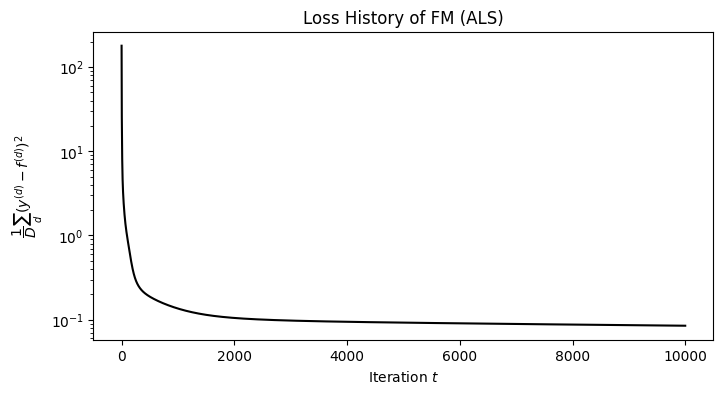

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
# plt.scatter(range(len(loss_hist))[::200], loss_hist[::200], s=50, marker='o', color='none', edgecolors='black')
plt.plot(loss_hist, color='black')
plt.yscale('log')
plt.xlabel(r'Iteration $t$')
plt.ylabel(r'$\dfrac{1}{D} \sum_{d} (y^{(d)} - f^{(d)})^2$')
plt.title('Loss History of FM (ALS)')
plt.show()